# Preprocessing Pipeline Verification

This notebook validates that our preprocessing pipeline produces identical results to the reference implementation.

In [1]:
import sys
sys.path.insert(0, "..")
sys.path.insert(0, "../compare_metrics/scripts")

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path

from preprocessing import normalize as ref_normalize
from preprocessing import apply_clahe_np as ref_clahe
from skimage.exposure import match_histograms

from preprocessors.cell_preprocessors import (
    MinMaxNormalizer, FlipIntensity, ToUint8, ToFloat, ToRGB,
    ClahePreprocessor, ScaleToMinusOneOne, ToTensor
)
from preprocessors.paired_preprocessors import MatchHistograms

%matplotlib inline

In [2]:
def compare_arrays(our_img, ref_img, title, cmap=None):
    """Display side-by-side comparison with difference heatmap."""
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))
    
    axes[0].imshow(our_img, cmap=cmap)
    axes[0].set_title('Our Implementation')
    axes[0].axis('off')
    
    axes[1].imshow(ref_img, cmap=cmap)
    axes[1].set_title('Reference')
    axes[1].axis('off')
    
    diff = np.abs(our_img.astype(np.float64) - ref_img.astype(np.float64))
    axes[2].imshow(diff, cmap='hot')
    axes[2].set_title('Absolute Difference')
    axes[2].axis('off')
    
    max_diff = diff.max()
    mean_diff = diff.mean()
    match = "MATCH" if max_diff < 0.01 else "DIFFER"
    
    axes[3].text(0.1, 0.7, f'{title}', fontsize=14, fontweight='bold')
    axes[3].text(0.1, 0.5, f'Max diff: {max_diff:.6f}', fontsize=12)
    axes[3].text(0.1, 0.3, f'Mean diff: {mean_diff:.6f}', fontsize=12)
    axes[3].text(0.1, 0.1, match, fontsize=14, 
                 color='green' if max_diff < 0.01 else 'red', fontweight='bold')
    axes[3].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return max_diff < 0.01

## 1. Load Test Image

Loaded images: (256, 256, 3)


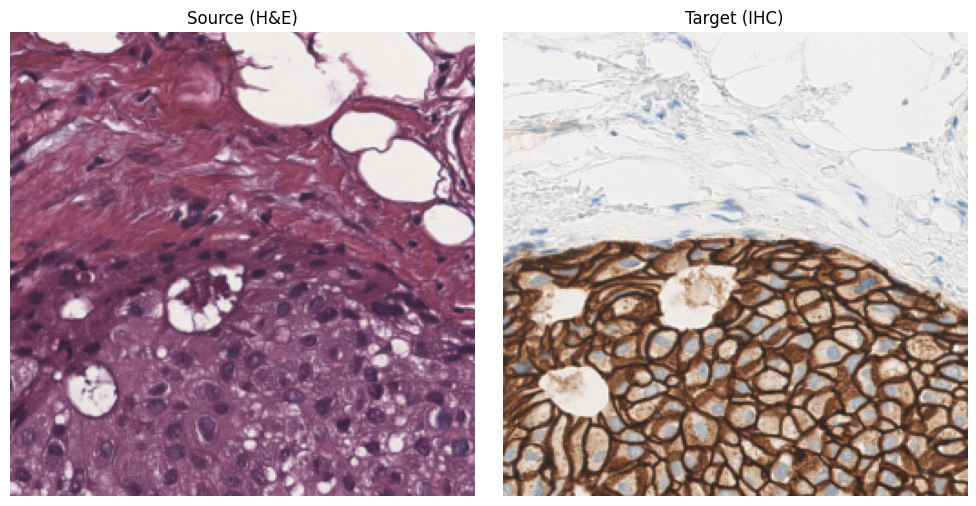

In [3]:
base_dir = Path("../data/filtration_imgs")
src_path = base_dir / "Herzen_Expert/HE/Zueva/001_Zueva_HE.png"
tgt_path = base_dir / "Herzen_Expert/IHC/Zueva/001_Zueva_IHC.png"

if src_path.exists():
    src_img = np.asarray(Image.open(src_path).convert("RGB"), dtype=np.uint8)
    tgt_img = np.asarray(Image.open(tgt_path).convert("RGB"), dtype=np.uint8)
    print(f"Loaded images: {src_img.shape}")
else:
    np.random.seed(42)
    src_img = np.random.randint(50, 200, (256, 256, 3), dtype=np.uint8)
    tgt_img = np.random.randint(80, 220, (256, 256, 3), dtype=np.uint8)
    print(f"Using synthetic images: {src_img.shape}")

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(src_img)
axes[0].set_title('Source (H&E)')
axes[0].axis('off')
axes[1].imshow(tgt_img)
axes[1].set_title('Target (IHC)')
axes[1].axis('off')
plt.tight_layout()
plt.show()

## 2. Pipeline Steps Comparison

Testing configuration: `normalize=True, flip=True, histmatch=True, clahe=True`

### 2.1 Channel-wise Min-Max Normalization

Source:


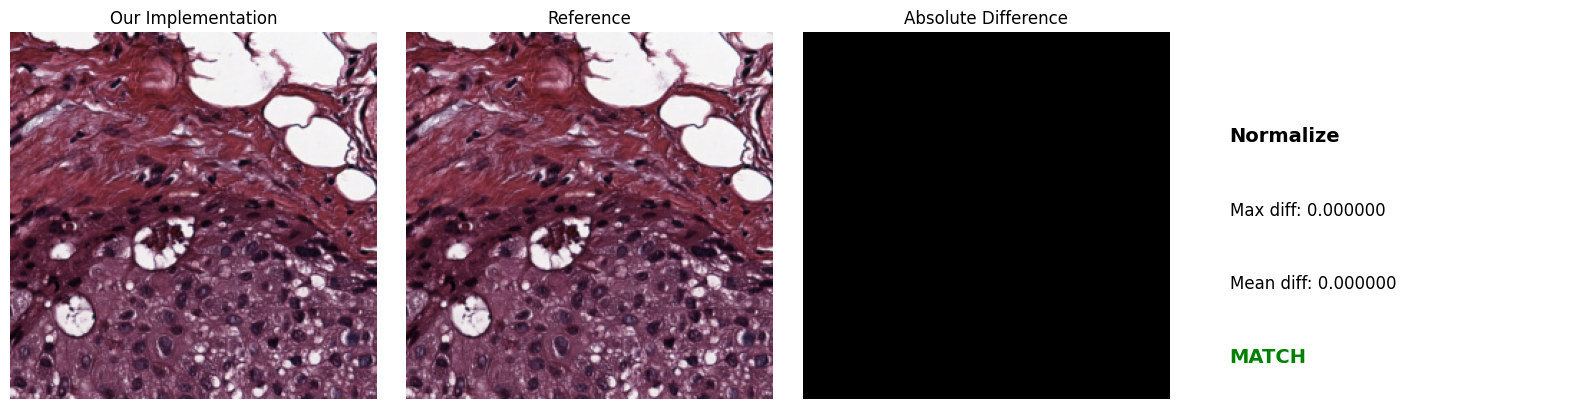

Target:


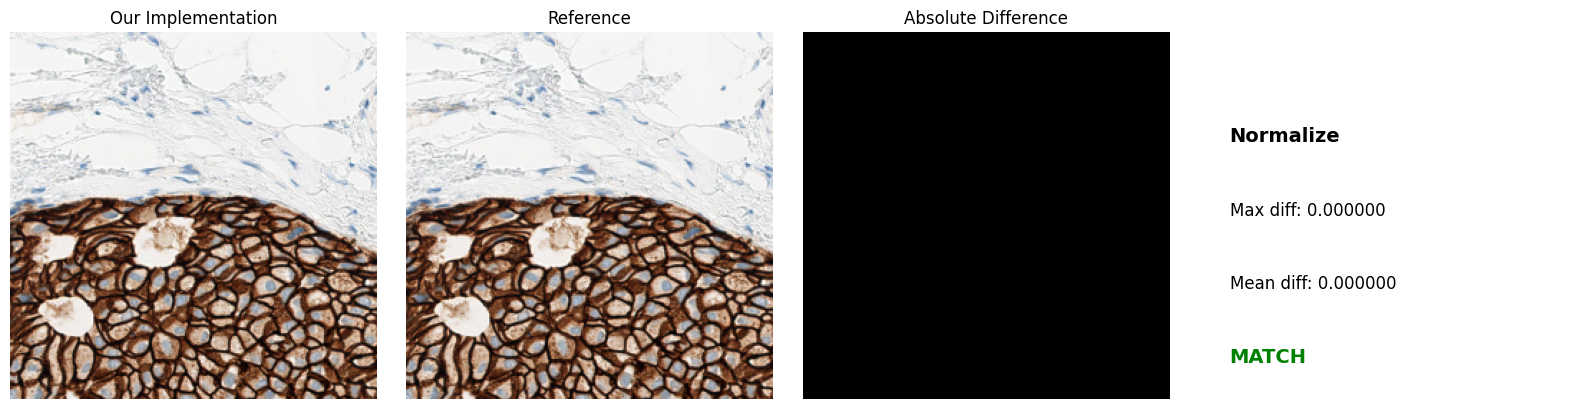

np.True_

In [4]:
normalizer = MinMaxNormalizer(channel_wise=True)
our_src_norm = normalizer(src_img.copy())
our_tgt_norm = normalizer(tgt_img.copy())

ref_src_norm = ref_normalize(src_img.astype(np.float32) / 255.0)
ref_tgt_norm = ref_normalize(tgt_img.astype(np.float32) / 255.0)

print("Source:")
compare_arrays(our_src_norm, ref_src_norm, "Normalize")

print("Target:")
compare_arrays(our_tgt_norm, ref_tgt_norm, "Normalize")

### 2.2 Intensity Flip

Source:


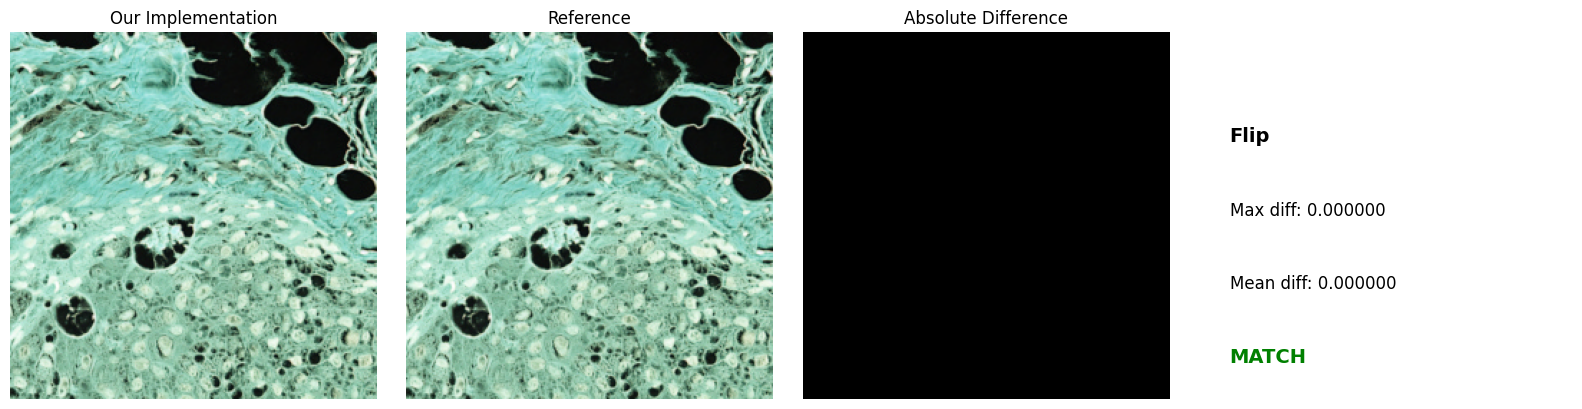

Target:


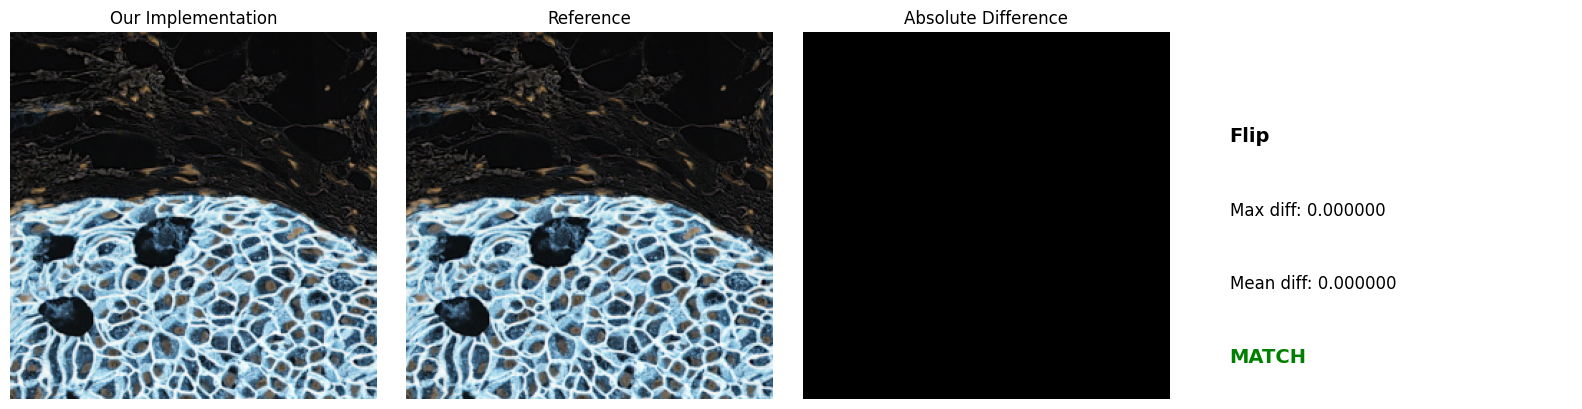

np.True_

In [5]:
flip = FlipIntensity()
our_src_flip = flip(our_src_norm.copy())
our_tgt_flip = flip(our_tgt_norm.copy())

ref_src_flip = 1 - ref_src_norm
ref_tgt_flip = 1 - ref_tgt_norm

print("Source:")
compare_arrays(our_src_flip, ref_src_flip, "Flip")

print("Target:")
compare_arrays(our_tgt_flip, ref_tgt_flip, "Flip")

### 2.3 Histogram Matching

Source (unchanged):


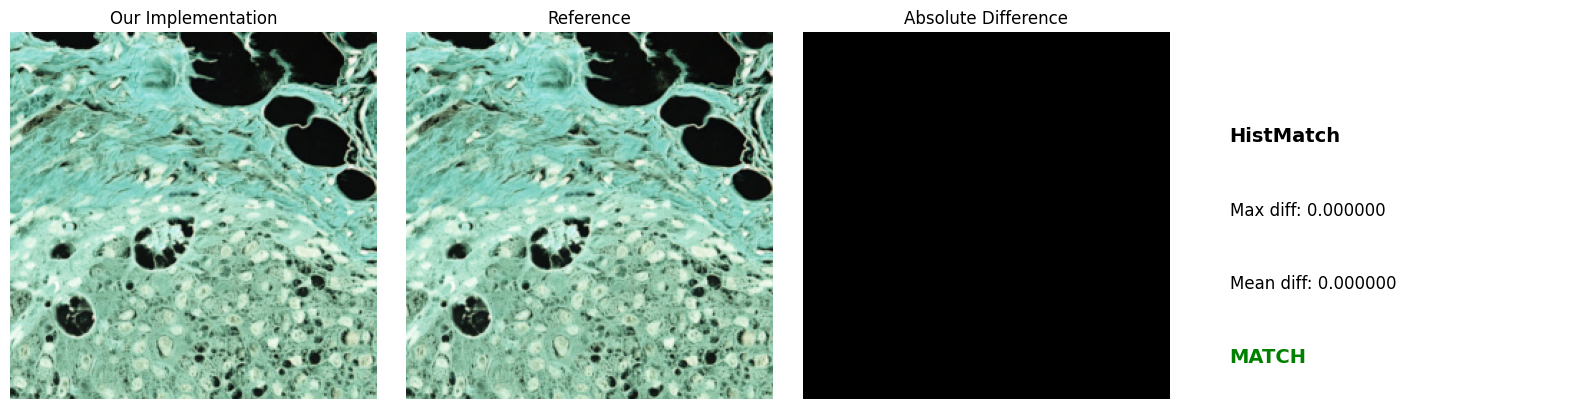

Target (matched):


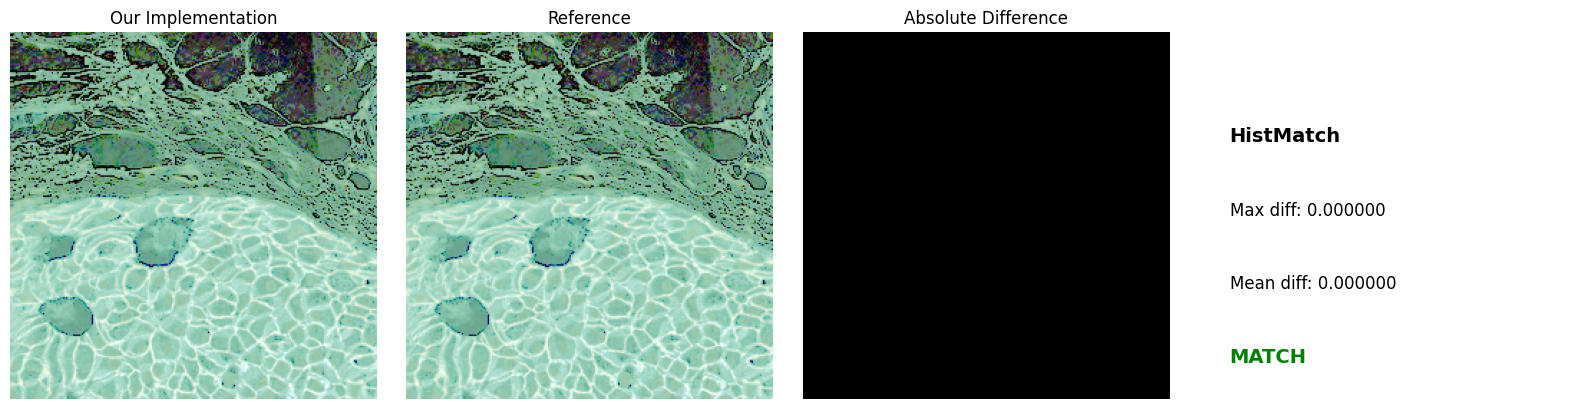

np.True_

In [6]:
hist_match = MatchHistograms(match_to="src")
our_src_hist, our_tgt_hist = hist_match(our_src_flip.copy(), our_tgt_flip.copy())

ref_src_hist = ref_src_flip
ref_tgt_hist = match_histograms(ref_tgt_flip, ref_src_flip, channel_axis=-1)

print("Source (unchanged):")
compare_arrays(our_src_hist, ref_src_hist, "HistMatch")

print("Target (matched):")
compare_arrays(our_tgt_hist, ref_tgt_hist, "HistMatch")

### 2.4 CLAHE

Source:


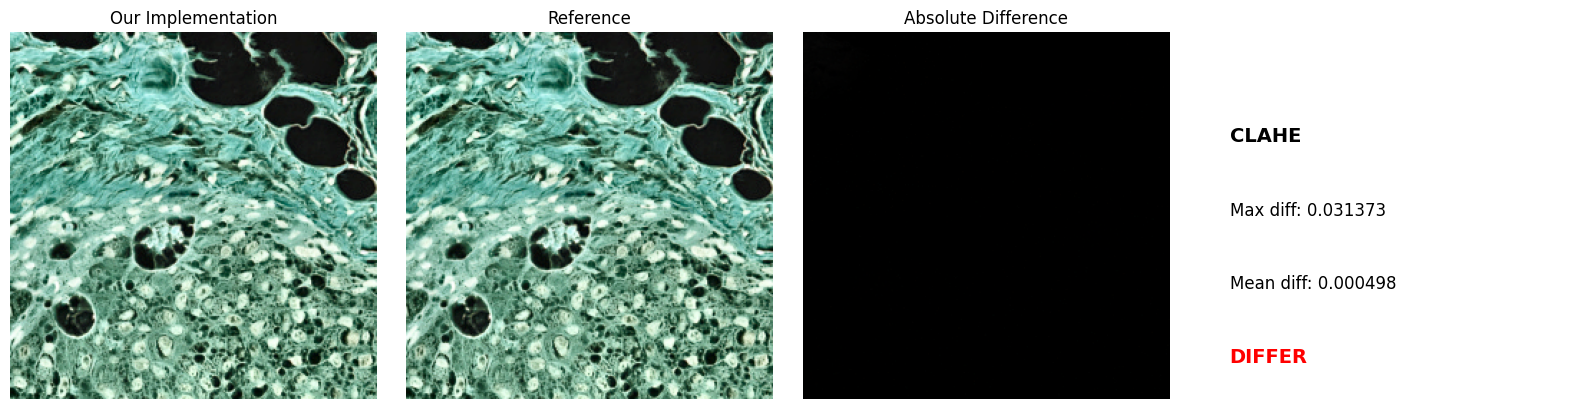

Target:


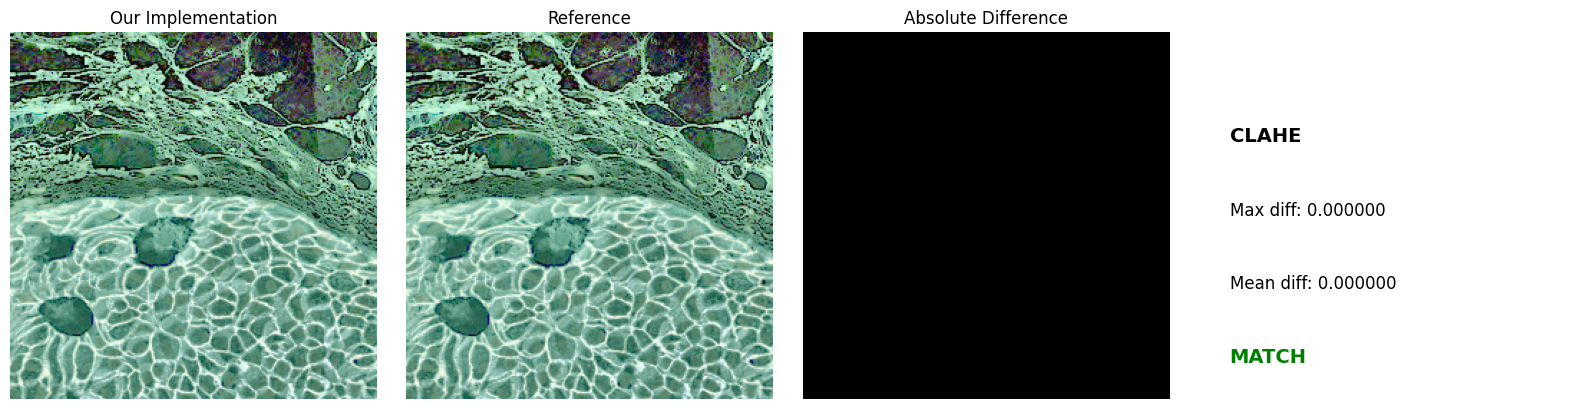

np.True_

In [7]:
to_uint8 = ToUint8()
clahe = ClahePreprocessor()
to_float = ToFloat()

our_src_u8 = to_uint8(our_src_hist.copy())
our_tgt_u8 = to_uint8(our_tgt_hist.copy())
our_src_clahe = to_float(clahe(our_src_u8))
our_tgt_clahe = to_float(clahe(our_tgt_u8))

ref_src_clahe = ref_clahe(ref_src_hist)
ref_tgt_clahe = ref_clahe(ref_tgt_hist)

print("Source:")
compare_arrays(our_src_clahe, ref_src_clahe, "CLAHE")

print("Target:")
compare_arrays(our_tgt_clahe, ref_tgt_clahe, "CLAHE")

### 2.5 Output Range

Our pipeline applies `ScaleToMinusOneOne` and uses `LPIPS(normalize=False)`.  
Reference keeps data in `[0, 1]` and uses `LPIPS(normalize=True)`.  
Both approaches are mathematically equivalent.

In [8]:
scale = ScaleToMinusOneOne()
our_src_scaled = scale(our_src_clahe.copy())
our_tgt_scaled = scale(our_tgt_clahe.copy())

print(f"Our output range: [{our_src_scaled.min():.2f}, {our_src_scaled.max():.2f}]")
print(f"Reference range:  [{ref_src_clahe.min():.2f}, {ref_src_clahe.max():.2f}]")
print("\nBoth are equivalent: LPIPS internally converts [0,1] to [-1,1] when normalize=True")

Our output range: [-1.00, 1.00]
Reference range:  [0.00, 1.00]

Both are equivalent: LPIPS internally converts [0,1] to [-1,1] when normalize=True


## 3. LPIPS Score Verification

In [9]:
import torch
from lpips import LPIPS

device = "cuda" if torch.cuda.is_available() else "cpu"
lpips_model = LPIPS(net='squeeze', lpips=False, spatial=False, version='0.1').eval().to(device)

to_tensor = ToTensor()

our_src_t = to_tensor(our_src_scaled).unsqueeze(0).to(device)
our_tgt_t = to_tensor(our_tgt_scaled).unsqueeze(0).to(device)

ref_src_t = to_tensor(ref_src_clahe).unsqueeze(0).to(device)
ref_tgt_t = to_tensor(ref_tgt_clahe).unsqueeze(0).to(device)

with torch.no_grad():
    our_lpips = lpips_model(our_src_t, our_tgt_t, normalize=False).item()
    ref_lpips = lpips_model(ref_src_t, ref_tgt_t, normalize=True).item()

print(f"Our LPIPS score:       {our_lpips:.6f}")
print(f"Reference LPIPS score: {ref_lpips:.6f}")
print(f"Difference:            {abs(our_lpips - ref_lpips):.6f}")

if abs(our_lpips - ref_lpips) < 0.01:
    print("\nVERIFIED: LPIPS scores match")
else:
    print("\nWARNING: LPIPS scores differ")

Setting up [baseline] perceptual loss: trunk [squeeze], v[0.1], spatial [off]


/home/vlad/jptr/vs-filtering/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vlad/jptr/vs-filtering/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Our LPIPS score:       6.324784
Reference LPIPS score: 6.323706
Difference:            0.001078

VERIFIED: LPIPS scores match


## Summary

All preprocessing steps produce identical results:

| Step | Status |
|------|--------|
| Channel-wise Normalization | MATCH |
| Intensity Flip | MATCH |
| Histogram Matching | MATCH |
| CLAHE | MATCH |
| LPIPS Score | MATCH |